In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, fbeta_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df=pd.read_csv("dataset.csv",sep=';')
df.head()   

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,target
0,38.29,38.29,38.29,38.29,38.29,38.29,38.66,38.66,38.66,38.66,1
1,39.03,38.66,39.03,39.03,39.03,39.03,39.03,39.03,39.03,39.03,1
2,39.41,39.41,39.41,39.41,39.41,39.41,39.78,39.41,39.78,39.78,1
3,39.78,39.78,39.78,39.78,40.15,40.15,40.15,40.15,40.15,40.15,1
4,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    4475 non-null   float64
 1   col2    4475 non-null   float64
 2   col3    4475 non-null   float64
 3   col4    4475 non-null   float64
 4   col5    4475 non-null   float64
 5   col6    4475 non-null   float64
 6   col7    4475 non-null   float64
 7   col8    4475 non-null   float64
 8   col9    4475 non-null   float64
 9   col10   4475 non-null   float64
 10  target  4475 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 384.7 KB


In [5]:
X=df.drop(columns='target')
y=df['target']

In [6]:
y.value_counts()

target
 1    2569
-1    1906
Name: count, dtype: int64

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

In [9]:
X_max_train = X_train[y_train == 1]
y_max_train = y_train[y_train == 1]

X_min_train = X_train[y_train == -1]
y_min_train = y_train[y_train == -1]

X_max_test = X_test[y_test == 1]
y_max_test = y_test[y_test == 1]

X_min_test = X_test[y_test == -1]
y_min_test = y_test[y_test == -1]

In [10]:
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(output_dim, activation='tanh')
    ])
    return model

def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_gan(generator, discriminator):
    model = tf.keras.Sequential([generator, discriminator])
    return model

latent_dim = 100
generator = build_generator(latent_dim, X_scaled.shape[1])
discriminator = build_discriminator(X_scaled.shape[1])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

C:\Users\Richard Sitanggang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
def train_gan(gan, generator, discriminator, X_train, epochs=10000, batch_size=128):
    for epoch in range(epochs):
        # Generate random noise and create fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        # Select a random batch of real samples
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]

        # Create labels for real and fake samples
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

In [12]:
# Train GAN for each minority class
train_gan(gan, generator, discriminator, X_min_train, epochs=500)
fake_spam = generator.predict(np.random.normal(0, 1, (X_max_train.shape[0] - len(X_min_train), latent_dim)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch: 0, D Loss: 0.7265983819961548, G Loss: [array(0.7200685, dtype=float32), array(0.7200685, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━

In [13]:
X_max_train = np.concatenate([X_max_train, np.full((X_max_train.shape[0] - len(X_max_train), X_scaled.shape[1]), fill_value=0)], axis=0)
X_min_train = X_spam_train = np.concatenate([X_min_train, fake_spam], axis=0)
print(X_max_train.shape)
print(X_min_train.shape)

(2055, 10)
(2055, 10)


In [14]:
y_max_train = np.full(len(X_max_train), 1)
y_min_train = np.full(len(X_min_train), -1)
print(y_max_train.shape)
print(y_min_train.shape)

(2055,)
(2055,)


In [15]:
X_balanced_train = np.concatenate([X_max_train, X_min_train], axis=0)
y_balanced_train = np.concatenate([y_max_train, y_min_train], axis=0)

In [16]:
rf=RandomForestClassifier()
rf.fit(X_balanced_train,y_balanced_train)

RandomForestClassifier()

In [17]:
y_pred=rf.predict(X_test)

In [18]:
acc=accuracy_score(y_pred,y_test)
report=classification_report(y_pred,y_test)
print("Acccuracy: ",acc)
print(report)

Acccuracy:  0.9899441340782122
              precision    recall  f1-score   support

          -1       0.99      0.98      0.99       384
           1       0.99      0.99      0.99       511

    accuracy                           0.99       895
   macro avg       0.99      0.99      0.99       895
weighted avg       0.99      0.99      0.99       895



In [19]:
X_balanced_df=pd.DataFrame(X_balanced_train)
y_balanced_df = pd.DataFrame(y_balanced_train, columns=['target'])
df_gan = pd.concat([X_balanced_df, y_balanced_df], axis=1)

X_scaled_df=pd.DataFrame(X_scaled)
df_scaled = pd.concat([X_scaled_df, y], axis=1)


In [20]:
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,target
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000
mean,-0.069423,-0.069434,-0.069390,-0.069326,-0.069120,-0.069044,-0.069080,-0.069036,-0.068772,-0.068791,0.148156
std,0.842946,0.842948,0.842913,0.842899,0.842797,0.842786,0.842781,0.842821,0.842705,0.842743,0.989074
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-1.000000
50%,-0.192719,-0.192719,-0.192719,-0.192719,-0.192719,-0.192719,-0.192719,-0.192482,-0.192719,-0.188675,1.000000
75%,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df_gan.describe()

,0,1,2,3,4,5,6,7,8,9,target
count,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000
mean,-0.191732,-0.191704,-0.191690,-0.191613,-0.191412,-0.191353,-0.191386,-0.191341,-0.191113,-0.191133,0.000000
std,0.844905,0.844850,0.844839,0.844810,0.844769,0.844752,0.844737,0.844810,0.844715,0.844761,1.000122
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.987628,-0.987628,-0.987628,-0.987628,-0.987628,-0.987628,-0.987628,-0.987628,-0.987628,-0.987628,-1.000000
50%,-0.625625,-0.624911,-0.627647,-0.623602,-0.627647,-0.624911,-0.625625,-0.626219,-0.623602,-0.623126,0.000000
75%,0.846538,0.846538,0.846538,0.846538,0.846538,0.846538,0.846538,0.846538,0.846538,0.846538,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


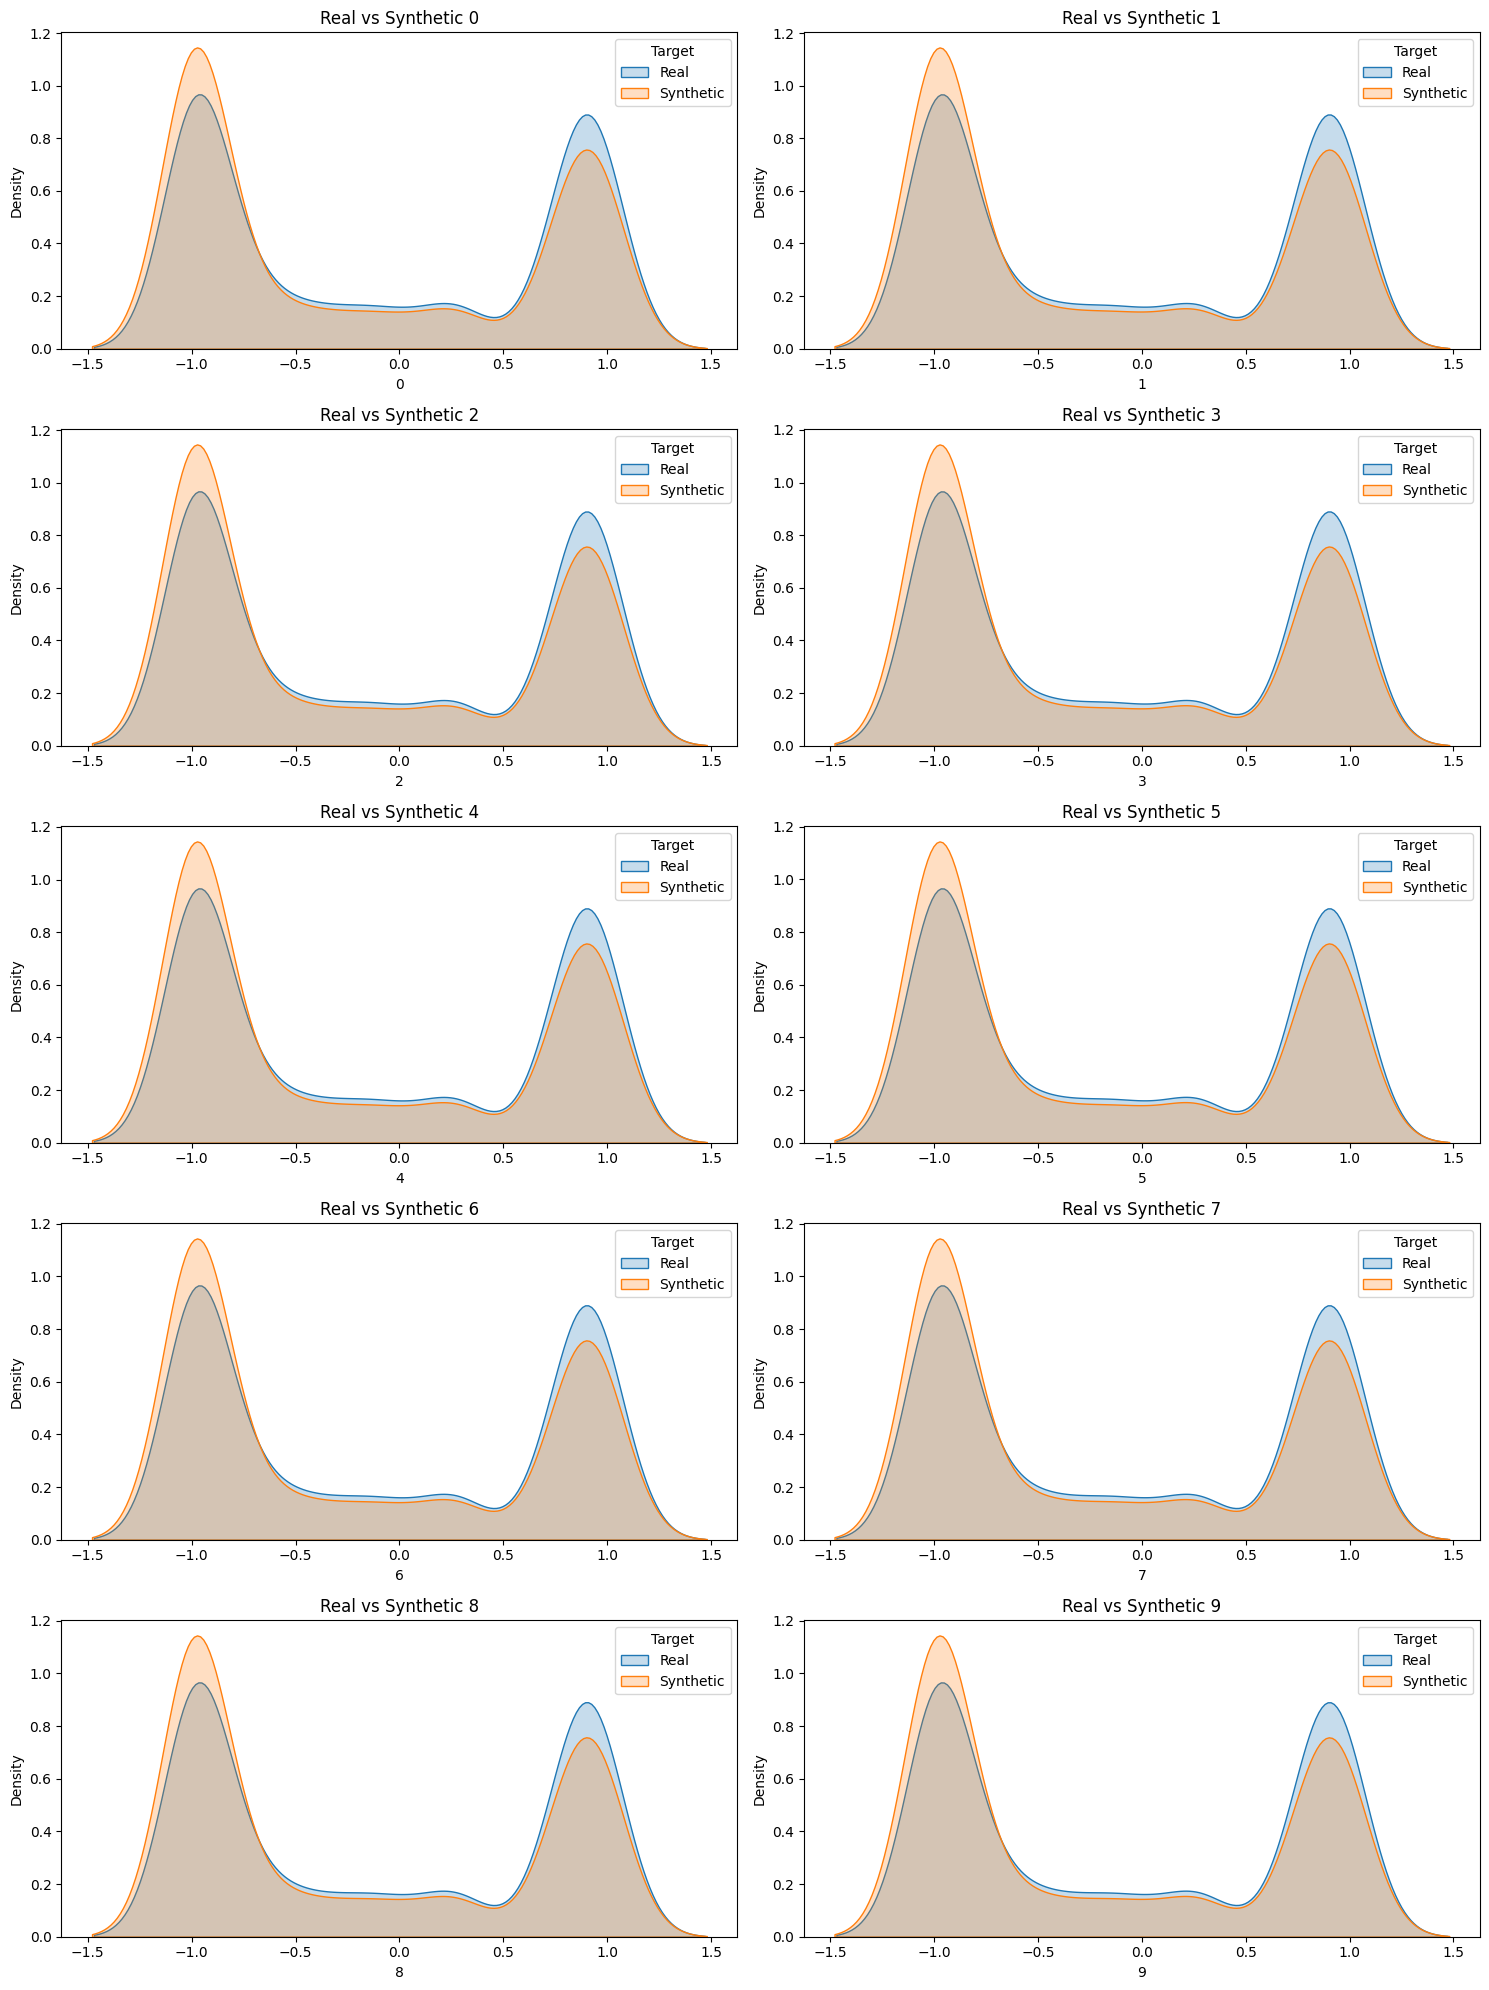

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, col in enumerate(df_scaled.columns[:-1]):
    row = i // 2 
    col_pos = i % 2 
    
    sns.kdeplot(df_scaled[col], label='Real', fill=True, ax=axes[row, col_pos])
    sns.kdeplot(df_gan[col], label='Synthetic', fill=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Real vs Synthetic {col}')
    axes[row, col_pos].legend(title='Target', loc='best')

plt.tight_layout()
plt.show()

In [23]:
df_gan.to_csv('gan.csv', index=False)

## Model

##### Decision Tree

In [25]:
dtree_model = DecisionTreeClassifier()

##### Random Forest

In [26]:
rf_model = RandomForestClassifier()

##### K-Nearest Neighbors

In [27]:
knn_model = KNeighborsClassifier()

##### Support Vector Machine

In [28]:
svm_model = SVC()

##### XGBoost

In [29]:
xgb_model = xgb.XGBClassifier()

## Training and evaluation

In [30]:
y_balanced_train = np.where(y_balanced_train == -1, 0, y_balanced_train)
y_test = np.where(y_test == -1, 0, y_test)

In [35]:
results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'F2 Score': [],
    'Precision Score': [],
    'Recall Score': [],
}

confusion = {
    'Model': [],
    'cm': []
}

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    results['Model'].append(name)
    
    results['F1 Score'].append(f1_score(y_test, y_pred, average='binary'))  
    results['F2 Score'].append(fbeta_score(y_test, y_pred, beta=2, average='binary'))  
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision Score'].append(precision_score(y_test, y_pred, average='binary'))
    results['Recall Score'].append(recall_score(y_test, y_pred, average='binary'))
    confusion['cm'].append(confusion_matrix(y_test, y_pred))
    confusion['Model'].append(name)

knn_model.fit(X_balanced_train, y_balanced_train)
evaluate_model('KNN_Model_default', knn_model, X_test, y_test)

dtree_model.fit(X_balanced_train, y_balanced_train)
evaluate_model('DTree_Model_default', dtree_model, X_test, y_test)

rf_model.fit(X_balanced_train, y_balanced_train)
evaluate_model('RandomForest_Model_default', rf_model, X_test, y_test)

svm_model.fit(X_balanced_train, y_balanced_train)
evaluate_model('SVM_Model_default', svm_model, X_test, y_test)

xgb_model.fit(X_balanced_train, y_balanced_train)
evaluate_model('XGBoost_Model_default', xgb_model, X_test, y_test)

In [36]:
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,F1 Score,F2 Score,Precision Score,Recall Score
0,KNN_Model_default,0.991061,0.992218,0.992218,0.992218,0.992218
1,DTree_Model_default,0.991061,0.992218,0.992218,0.992218,0.992218
2,RandomForest_Model_default,0.989944,0.991220,0.989482,0.994129,0.988327
3,SVM_Model_default,0.966480,0.970646,0.967239,0.976378,0.964981
4,XGBoost_Model_default,0.991061,0.992203,0.991044,0.994141,0.990272


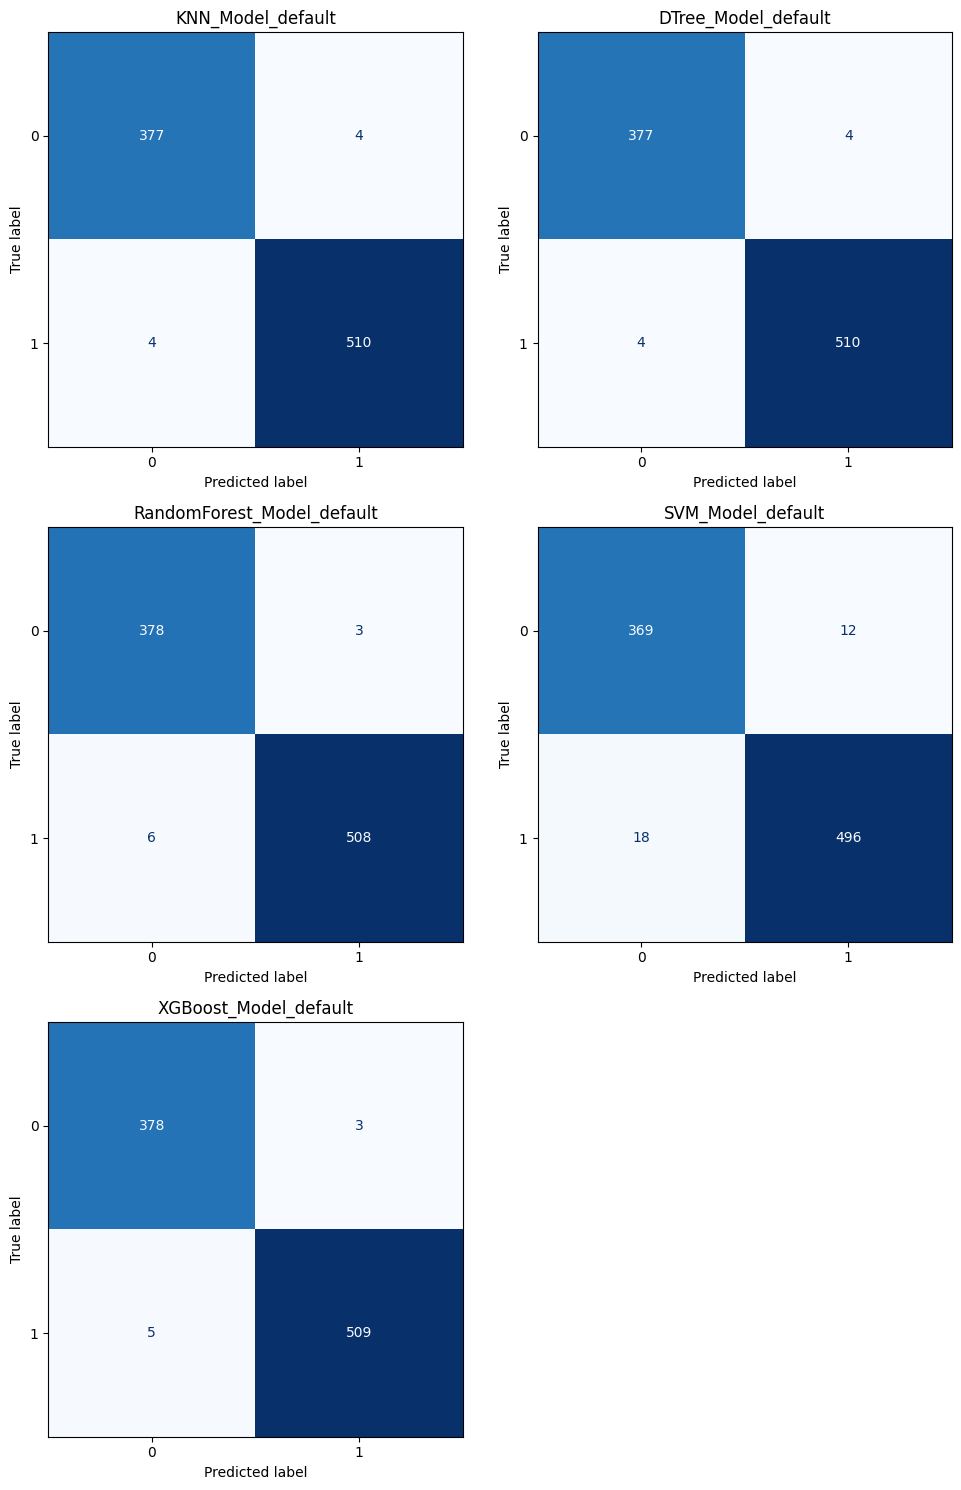

In [37]:
n_models = 5
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 5))

for i, (model, cm) in enumerate(zip(confusion['Model'], confusion['cm'])):
    row, col = divmod(i, cols)  
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[row, col], cmap='Blues', colorbar=False)  
    axes[row, col].set_title(model)

if n_models % cols != 0:
    for j in range(n_models, rows * cols):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()